In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, StratifiedKFold, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, roc_curve, roc_auc_score, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from scipy.stats import randint, uniform
from modfunctions import train_model_GridSearch, train_model_RandomizedSearch, plot_roc, export_file, record_results

## Load data

In [2]:
wine_path_red='../0. Project Data/Processed Data/2. scaled/scaled_red.csv'
wine_path_white='../0. Project Data/Processed Data/2. scaled/scaled_white.csv'
r_df=pd.read_csv(wine_path_red, sep=',')
w_df=pd.read_csv(wine_path_white, sep=',')
df=pd.concat([r_df,w_df])

## Binning data

Our response variable comes from a 'quality' distribution that ranges from 0-10. In order to apply a binary Logistic regression model to this dataset, we have to bin our response variable into 'low' and 'high' quality. Here we bin the 0-6 quality wines into 'low' and the 7-10 quality wines into 'high'.

In [3]:
quality_freq=df['quality'].value_counts().sort_index()
quality_freq

3      30
4     206
5    1752
6    2323
7     856
8     148
9       5
Name: quality, dtype: int64

In [4]:
ranges=[0,6,10]
group_names=['low', 'high']
df['quality_bin']=pd.cut(df['quality'], bins=ranges, labels=group_names)

In [5]:
df['quality_bin'].value_counts().sort_index()

low     4311
high    1009
Name: quality_bin, dtype: int64

In [6]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,wine_type,quality_bin
0,0.247788,0.397260,0.00,0.068493,0.106845,0.140845,0.098940,0.567548,0.606299,0.137725,0.153846,5,red,low
1,0.283186,0.520548,0.00,0.116438,0.143573,0.338028,0.215548,0.494126,0.362205,0.209581,0.215385,5,red,low
2,0.283186,0.438356,0.04,0.095890,0.133556,0.197183,0.169611,0.508811,0.409449,0.191617,0.215385,5,red,low
3,0.584071,0.109589,0.56,0.068493,0.105175,0.225352,0.190813,0.582232,0.330709,0.149701,0.215385,6,red,low
4,0.247788,0.369863,0.00,0.061644,0.105175,0.169014,0.120141,0.567548,0.606299,0.137725,0.153846,5,red,low


## Modeling Red Wine

In [7]:
y_red = df[df['wine_type']=='red']['quality_bin']
X_red = df.drop(['quality', 'quality_bin', 'wine_type'], axis=1)[df['wine_type']=='red']
X_train_red, X_test_red, y_train_red, y_test_red= train_test_split(X_red, y_red, test_size=.2,random_state=123)
num_features=X_red.shape[1]
red_scores=[]

### Logistic Regression

We set up a pipeline that includes scaling the data using RobustScaler and a grid search over the the parameters penalty (lasso vs ridge regression regularization) and C (regularization strength)

In [8]:
LR_steps=[('LogReg', LogisticRegression(solver='liblinear'))]
LR_parameters= {'LogReg__penalty': ['l1', 'l2'],
                'LogReg__C': [0.01, 0.1, 1.0, 10.0, 100.0,1000.0]
               }
LR_cv_red=train_model_GridSearch(X_train_red, y_train_red, LR_steps, LR_parameters)
LR_cv_red.best_params_

{'LogReg__C': 10.0, 'LogReg__penalty': 'l2'}

#### Logistic Regression ROC Curve

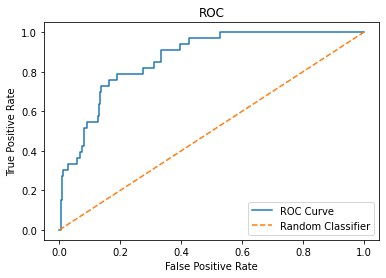

In [9]:
plot_roc(LR_cv_red, X_test_red, y_test_red)

In [10]:
LR_results_red=record_results('Logistic Regression', LR_cv_red, X_test_red, y_test_red)
red_scores.append(LR_results_red)

### PCA with Logistic Regression

This pipeline is the same as the previous but with added PCA preprocessing step.

In [11]:
PCA_LR_steps=[('pca',PCA()),('LogReg', LogisticRegression(solver='liblinear'))]
PCA_LR_parameters={'pca__n_components':list(np.arange(1,num_features+1)),
                   'LogReg__penalty': ['l1', 'l2'],
                   'LogReg__C': [0.01, 0.1, 1.0, 10.0, 100.0,1000.0]
                  }
PCA_LR_cv_red=train_model_GridSearch(X_train_red, y_train_red, PCA_LR_steps, PCA_LR_parameters)
PCA_LR_cv_red.best_params_

{'LogReg__C': 10.0, 'LogReg__penalty': 'l2', 'pca__n_components': 9}

#### PCA Logistic Regression ROC Curve

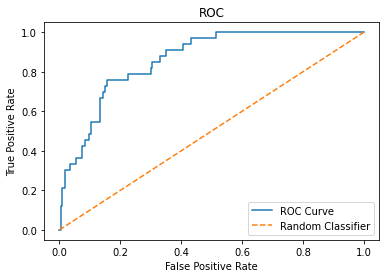

In [12]:
plot_roc(PCA_LR_cv_red, X_test_red, y_test_red)

In [13]:
PCA_LR_results_red=record_results('PCA Logistic Regression', PCA_LR_cv_red, X_test_red, y_test_red)
red_scores.append(PCA_LR_results_red)

### Random Forest

We set up a Random Forest model that employs a RandomizedSearch CV over the the parameters 

n_estimators : number of trees in the forest

max_depth : maximum depth of the tree

min_samples_split : minimum number of samples required to split a node

min_samples_leaf : minimum number of samples required to be at a leaf node

max_features : number of features to consider when looking for the best split

criterion : loss function to measure the quality of a split

In [14]:
RF_steps=[('randomForest', RandomForestClassifier())]
RF_parameters={'randomForest__n_estimators': randint(20, 300), 
             'randomForest__max_depth': randint(10,100),
             'randomForest__min_samples_split': randint(2,10),
             'randomForest__min_samples_leaf' : randint(1,10),
             'randomForest__max_features' : np.arange(num_features)+1,
             'randomForest__criterion': ['gini', 'entropy']
              }
RF_cv_red=train_model_RandomizedSearch(X_train_red, y_train_red, RF_steps, RF_parameters)
RF_cv_red.best_params_

{'randomForest__criterion': 'entropy',
 'randomForest__max_depth': 35,
 'randomForest__max_features': 4,
 'randomForest__min_samples_leaf': 5,
 'randomForest__min_samples_split': 2,
 'randomForest__n_estimators': 228}

#### Random Forest ROC Curve

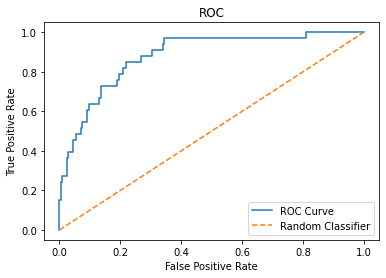

In [15]:
plot_roc(RF_cv_red, X_test_red, y_test_red)

In [16]:
RF_results_red=record_results('Random Forest', RF_cv_red, X_test_red, y_test_red)
red_scores.append(RF_results_red)

### Gradient Boosted Tree

We set up a Gradient Boosted Tree model that employs a RandomizedSearchCV over the the parameters 

learning_rate : how fast individual trees learn 

n_estimators : number of boosted trees

subsample : fraction of data used to train each tree

min_samples_split : minimum number of samples required to split a node

max_depth : max depth of a tree

max_features : number of features to consider when looking for the best split

min_samples_leaf : minimum number of samples required to be at a leaf node

In [17]:
GBT_steps=[('GBT', GradientBoostingClassifier())]
GBT_parameters= {'GBT__learning_rate': uniform(0,3),
                 'GBT__n_estimators': randint(1,1000),
                 'GBT__subsample' : uniform(0,1),
                 'GBT__min_samples_split': randint(2,10),
                 'GBT__max_depth' : randint(1,10),
                 'GBT__max_features' : np.arange(num_features)+1,
                 'GBT__min_samples_leaf': randint(1,10)
                }
GBT_cv_red=train_model_RandomizedSearch(X_train_red, y_train_red, GBT_steps, GBT_parameters)
GBT_cv_red.best_params_

{'GBT__learning_rate': 0.3516205136085174,
 'GBT__max_depth': 6,
 'GBT__max_features': 2,
 'GBT__min_samples_leaf': 5,
 'GBT__min_samples_split': 5,
 'GBT__n_estimators': 771,
 'GBT__subsample': 0.521010875426266}

#### Gradient Boosted Tree ROC Curve

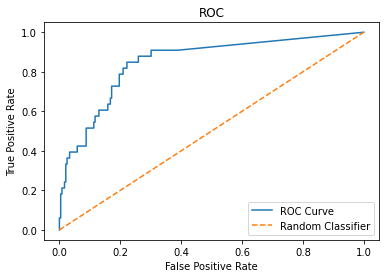

In [18]:
plot_roc(GBT_cv_red, X_test_red, y_test_red)

In [19]:
GBT_results_red=record_results('Gradient Boosted Tree', GBT_cv_red, X_test_red, y_test_red)
red_scores.append(GBT_results_red)

### Red Wine Results

In [20]:
red_results= pd.DataFrame(red_scores, columns=['Model Name', 'f1 score', 'test_acc', 'roc'])
red_results.index.name='Red Wine'
red_results

,Model Name,f1 score,test_acc,roc
Red Wine,,,,
0,Logistic Regression,0.415094,0.886029,0.867377
1,PCA Logistic Regression,0.415094,0.886029,0.861544
2,Random Forest,0.456140,0.886029,0.879295
3,Gradient Boosted Tree,0.459016,0.878676,0.848992


## Modeling White Wine

In [21]:
y_white = df[df['wine_type']=='white']['quality_bin']
X_white = df.drop(['quality', 'quality_bin', 'wine_type'], axis=1)[df['wine_type']=='white']
X_train_white, X_test_white, y_train_white, y_test_white= train_test_split(X_white, y_white, test_size=.2,random_state=123)
num_features=X_white.shape[1]
white_scores=[]

### Logistic Regression

In [22]:
LR_steps=[('LogReg', LogisticRegression(solver='liblinear'))]
LR_parameters= {'LogReg__penalty': ['l1', 'l2'],
                'LogReg__C': [0.01, 0.1, 1.0, 10.0, 100.0,1000.0]
               }
LR_cv_white=train_model_GridSearch(X_train_white, y_train_white, LR_steps, LR_parameters)
LR_cv_white.best_params_

{'LogReg__C': 1000.0, 'LogReg__penalty': 'l1'}

#### Logistic Regression ROC Curve

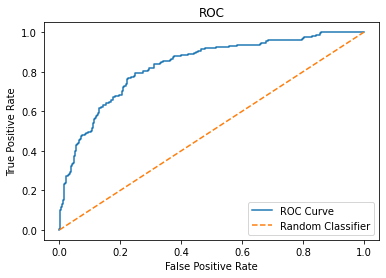

In [23]:
plot_roc(LR_cv_white, X_test_white, y_test_white)

In [24]:
LR_results_white=record_results('Logistic Regression', LR_cv_white, X_test_white, y_test_white)
white_scores.append(LR_results_white)

### PCA with Logistic Regression

In [25]:
PCA_LR_steps=[('pca',PCA()),('LogReg', LogisticRegression(solver='liblinear'))]
PCA_LR_parameters={'pca__n_components':list(np.arange(1,num_features+1)),
                   'LogReg__penalty': ['l1', 'l2'],
                   'LogReg__C': [0.01, 0.1, 1.0, 10.0, 100.0,1000.0]
                  }
PCA_LR_cv_white=train_model_GridSearch(X_train_white, y_train_white, PCA_LR_steps, PCA_LR_parameters)
PCA_LR_cv_white.best_params_

{'LogReg__C': 1000.0, 'LogReg__penalty': 'l1', 'pca__n_components': 11}

#### PCA Logistic Regression ROC Curve

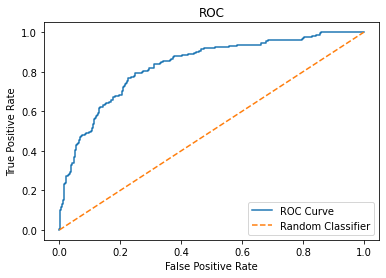

In [26]:
plot_roc(PCA_LR_cv_white, X_test_white, y_test_white)

In [27]:
PCA_LR_results_white=record_results('PCA Logistic Regression', PCA_LR_cv_white, X_test_white, y_test_white)
white_scores.append(PCA_LR_results_white)

### Random Forest

In [28]:
RF_steps=[('randomForest', RandomForestClassifier())]
RF_parameters={'randomForest__n_estimators': randint(20, 300), 
             'randomForest__max_depth': randint(10,100),
             'randomForest__min_samples_split': randint(2,10),
             'randomForest__min_samples_leaf' : randint(1,10),
             'randomForest__max_features' : np.arange(num_features)+1,
             'randomForest__criterion': ['gini', 'entropy']
              }
RF_cv_white=train_model_RandomizedSearch(X_train_white, y_train_white, RF_steps, RF_parameters)
RF_cv_white.best_params_

{'randomForest__criterion': 'entropy',
 'randomForest__max_depth': 35,
 'randomForest__max_features': 4,
 'randomForest__min_samples_leaf': 5,
 'randomForest__min_samples_split': 2,
 'randomForest__n_estimators': 228}

#### Random Forest ROC Curve

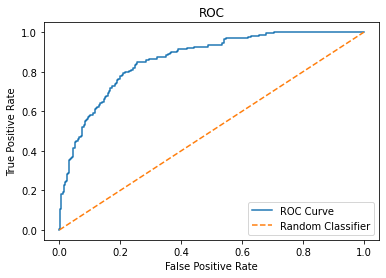

In [29]:
plot_roc(RF_cv_white, X_test_white, y_test_white)

In [30]:
RF_results_white=record_results('Random Forest', RF_cv_white, X_test_white, y_test_white)
white_scores.append(RF_results_white)

### Gradient Boosted Tree

In [31]:
GBT_steps=[('GBT', GradientBoostingClassifier())]
GBT_parameters= {'GBT__learning_rate': uniform(0,3),
                 'GBT__n_estimators': randint(1,1000),
                 'GBT__subsample' : uniform(0,1),
                 'GBT__min_samples_split': randint(2,10),
                 'GBT__max_depth' : randint(1,10),
                 'GBT__max_features' : np.arange(num_features)+1,
                 'GBT__min_samples_leaf': randint(1,10)
                }
GBT_cv_white=train_model_RandomizedSearch(X_train_white, y_train_white, GBT_steps, GBT_parameters)
GBT_cv_white.best_params_

{'GBT__learning_rate': 0.20234590539015518,
 'GBT__max_depth': 8,
 'GBT__max_features': 9,
 'GBT__min_samples_leaf': 9,
 'GBT__min_samples_split': 9,
 'GBT__n_estimators': 28,
 'GBT__subsample': 0.9839275636184652}

#### Gradient Boosted Tree ROC Curve

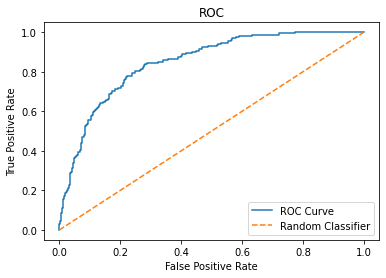

In [32]:
plot_roc(GBT_cv_white, X_test_white, y_test_white)

In [33]:
GBT_results_white=record_results('Gradient Boosted Tree', GBT_cv_white, X_test_white, y_test_white)
white_scores.append(GBT_results_white)

In [34]:
white_results= pd.DataFrame(white_scores, columns=['Model Name', 'f1 score', 'test_acc', 'roc'])
white_results.index.name='White Wine'
white_results

,Model Name,f1 score,test_acc,roc
White Wine,,,,
0,Logistic Regression,0.424000,0.818411,0.831727
1,PCA Logistic Regression,0.424000,0.818411,0.831801
2,Random Forest,0.484615,0.831021,0.863174
3,Gradient Boosted Tree,0.487455,0.819672,0.848023


## Export Model and Model Metrics

In [35]:
export_path_red='./Model Metrics/Red Wine/'
export_path_white='./Model Metrics/White Wine/'

In [36]:
export_file(export_path_red, 'logistic_regression_red.pkl', LR_cv_red)
export_file(export_path_red, 'PCA_logistic_regression_red.pkl', PCA_LR_cv_red)
export_file(export_path_red, 'random_forest_red.pkl', RF_cv_red)
export_file(export_path_red, 'gradient_boosted_tree_red.pkl', GBT_cv_red)
red_results.to_csv(export_path_red + 'Red_Wine_Performance_Metrics.csv',index=False)

In [37]:
export_file(export_path_white, 'logistic_regression_white.pkl', LR_cv_white)
export_file(export_path_white, 'PCA_logistic_regression_white.pkl', PCA_LR_cv_white)
export_file(export_path_white, 'random_forest_white.pkl', RF_cv_white)
export_file(export_path_white, 'gradient_boosted_tree_white.pkl', GBT_cv_white)
white_results.to_csv(export_path_white + 'White_Wine_Performance_Metrics.csv',index=False)

In [38]:
red_results

,Model Name,f1 score,test_acc,roc
Red Wine,,,,
0,Logistic Regression,0.415094,0.886029,0.867377
1,PCA Logistic Regression,0.415094,0.886029,0.861544
2,Random Forest,0.456140,0.886029,0.879295
3,Gradient Boosted Tree,0.459016,0.878676,0.848992


In [39]:
white_results

,Model Name,f1 score,test_acc,roc
White Wine,,,,
0,Logistic Regression,0.424000,0.818411,0.831727
1,PCA Logistic Regression,0.424000,0.818411,0.831801
2,Random Forest,0.484615,0.831021,0.863174
3,Gradient Boosted Tree,0.487455,0.819672,0.848023


### Conclusion

Out of our 4 models: logistic regression, logistic regression with PCA, random forest, and gradient boosted trees, it seems like the random forest model works best with the red wine and white wine data.